<a href="https://colab.research.google.com/github/aiexplorations/RagaExperiments/blob/master/Ragaflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pydub

In [3]:
import glob

# Importing drive method from colab for accessing google drive
from google.colab import drive

drive.mount('/content/drive')


data_files = glob.glob("/content/drive/My Drive/AIExplorations/carnatic_ragas_data/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls "/content/drive/My Drive/AIExplorations/carnatic_ragas_data/new_processed_data"

bhairavi  kalyani  kambhoji  kharaharapriya  shankarabharanam  thodi  varali


In [5]:
import numpy as np
from pydub import AudioSegment
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import pandas as pd

In [6]:
basepath = "/content/drive/My Drive/AIExplorations/carnatic_ragas_data/new_processed_data"
ragas = []
for entry in os.listdir(basepath):
    if os.path.isdir(os.path.join(basepath, entry)):
        print(entry)
        ragas.append(entry)


kharaharapriya
varali
kalyani
bhairavi
shankarabharanam
kambhoji
thodi


In [7]:
dataset = {}
NUMFILES = 200
SNIPPETSIZE = 100000
for raga in ragas:
    #sequence list in which to store all the sequences from each file
    sequence_list = []
    files = os.listdir(os.path.join(basepath, raga))
    print("Processing files for raga ",raga, "...")
    for file in files[0:NUMFILES]: 
        filename = os.path.join(basepath, raga, file)
        sound = AudioSegment.from_file(filename, sample_rate_Hz=12000, sample_width = 1, channels = 1, format = 'mp3')
        sequence_list.append(sound.get_array_of_samples()[0:SNIPPETSIZE])
    padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence_list)
    dataset[raga] = padded_sequence

Processing files for raga  kharaharapriya ...
Processing files for raga  varali ...
Processing files for raga  kalyani ...
Processing files for raga  bhairavi ...
Processing files for raga  shankarabharanam ...
Processing files for raga  kambhoji ...
Processing files for raga  thodi ...


In [8]:
n_records = len(dataset)*NUMFILES

In [9]:
raga_dict = {value: idx for idx, value in enumerate(ragas)}

In [28]:
raga_dict

{'bhairavi': 3,
 'kalyani': 2,
 'kambhoji': 5,
 'kharaharapriya': 0,
 'shankarabharanam': 4,
 'thodi': 6,
 'varali': 1}

In [10]:
prepared_data = []
prepared_labels = []

for key, value in dataset.items():
  for row in value:
    if len(row) < SNIPPETSIZE:
      t = SNIPPETSIZE - len(row)
      row = np.pad(row, (0,t), "constant") #padding logic to solve the problem of different sequence lengths
    prepared_data.append(row)
    prepared_labels.append(raga_dict[key])
prepared_data = np.vstack(prepared_data).reshape(n_records, SNIPPETSIZE, 1)
prepared_labels = np.stack(prepared_labels)

In [11]:
prepared_data.shape

(1400, 100000, 1)

In [12]:
prepared_labels

array([0, 0, 0, ..., 6, 6, 6])

In [13]:
print(len(prepared_data), len(prepared_labels))

1400 1400


In [14]:
seq_size, n_input = prepared_data[0].shape[0], len(prepared_data)

In [15]:
print(seq_size, n_input)

100000 1400


In [16]:
from keras.utils.np_utils import to_categorical   

categorical_labels = to_categorical(prepared_labels, num_classes=len(set(prepared_labels)))

Using TensorFlow backend.


In [17]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Flatten, TimeDistributed, Conv1D, MaxPooling1D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l1_l2
from sklearn.model_selection import train_test_split

In [18]:
prepared_data.shape, len(prepared_labels)

((1400, 100000, 1), 1400)

In [19]:
train_x, test_x, train_y, test_y = train_test_split(prepared_data, np.array(prepared_labels), test_size = 0.3 )

In [20]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((980, 100000, 1), (980,), (420, 100000, 1), (420,))

In [21]:
test_y

array([2, 0, 0, 5, 1, 5, 6, 5, 5, 4, 6, 0, 1, 0, 3, 1, 0, 6, 4, 1, 5, 4,
       0, 4, 3, 2, 6, 3, 5, 4, 0, 3, 0, 4, 2, 2, 2, 5, 5, 2, 4, 5, 5, 5,
       6, 5, 2, 4, 5, 4, 5, 4, 2, 5, 0, 2, 3, 5, 2, 0, 2, 1, 4, 6, 2, 2,
       4, 3, 2, 1, 6, 2, 3, 6, 3, 5, 4, 2, 6, 6, 5, 2, 6, 0, 6, 5, 1, 1,
       2, 5, 3, 0, 6, 1, 2, 5, 4, 0, 0, 0, 0, 0, 5, 0, 0, 2, 5, 0, 6, 2,
       3, 0, 6, 6, 4, 1, 0, 0, 0, 5, 3, 3, 2, 5, 1, 6, 4, 6, 2, 6, 4, 6,
       0, 3, 4, 5, 2, 3, 4, 3, 4, 2, 1, 2, 0, 5, 2, 1, 1, 0, 2, 1, 2, 5,
       6, 2, 3, 0, 2, 3, 1, 0, 4, 2, 2, 1, 3, 4, 5, 4, 4, 6, 4, 1, 1, 6,
       2, 3, 3, 4, 3, 6, 6, 0, 0, 3, 5, 2, 6, 3, 0, 5, 6, 2, 1, 0, 3, 4,
       0, 0, 3, 6, 1, 6, 2, 0, 6, 4, 0, 1, 6, 3, 2, 6, 2, 6, 6, 2, 3, 4,
       4, 4, 4, 0, 0, 2, 0, 0, 0, 3, 4, 5, 3, 6, 5, 3, 4, 1, 2, 6, 0, 5,
       4, 5, 5, 0, 5, 5, 2, 1, 4, 0, 0, 0, 1, 0, 0, 2, 5, 5, 0, 6, 3, 4,
       5, 0, 1, 5, 0, 3, 0, 2, 1, 2, 0, 1, 5, 0, 1, 0, 0, 1, 2, 1, 0, 2,
       3, 0, 3, 5, 1, 6, 1, 0, 4, 3, 5, 2, 6, 6, 2,

In [23]:
batchsize = 32
epochs = 100
n_units = 32
n_hidden = 32
lr = 1e-3
decay = 0.1 * lr
dropout_pc = 0.01
l1, l2 = 0.01, 0.01
n_classes = len(set(train_y))

In [507]:
n_classes

7

In [24]:
model = Sequential([
    TimeDistributed(Conv1D(filters = 100, kernel_size = 10, padding = 'same', activation = 'relu', strides=4), 
                    batch_input_shape = (None, 1, seq_size, 1) ),
    TimeDistributed(Conv1D(filters = 50, kernel_size = 5, padding = 'same', activation = 'relu', strides=2)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling1D(pool_size=100)),
    TimeDistributed(Flatten()),
    LSTM(units = n_units, activation = "relu", kernel_regularizer = l1_l2(l1, l2), 
         input_shape = (seq_size, 1), return_sequences = True),
    Dense(n_hidden, activation = "tanh"),
    LSTM(units = n_units, activation = "relu", kernel_regularizer = l1_l2(l1, l2), 
         dropout = dropout_pc, return_sequences = False),
    Dense(n_hidden, activation = "relu"),
    BatchNormalization(),
    Dense(n_hidden, activation = "tanh"),
    BatchNormalization(),
    Dense(n_hidden, activation = "relu"),
    Dropout(dropout_pc),
    Dense(n_classes, activation = "softmax")
    ])

In [25]:
model.compile(optimizer = 'adam', loss= 'sparse_categorical_crossentropy', metrics= ['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 1, 25000, 100)     1100      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 12500, 50)      25050     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 12500, 50)      200       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1, 125, 50)        0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 1, 6250)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 32)             804224    
_________________________________________________________________
dense_1 (Dense)              (None, 1, 32)            

In [26]:
len(train_x.reshape((train_x.shape[0], 1, train_x.shape[1], 1))), len(train_y)

(980, 980)

In [27]:
history = model.fit(x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1], 1)), 
                    y = train_y, 
                    batch_size= batchsize, 
                    epochs= epochs, 
                    verbose= 1,
                    validation_data=[test_x.reshape((test_x.shape[0], 1, test_x.shape[1], 1)), test_y])

Train on 980 samples, validate on 420 samples
Epoch 1/100
980/980 [==============================] - 13s 14ms/step - loss: 68.0610 - acc: 0.3235 - val_loss: 25.5126 - val_acc: 0.1714
Epoch 2/100
980/980 [==============================] - 4s 4ms/step - loss: 16.3372 - acc: 0.5398 - val_loss: 11.1997 - val_acc: 0.3286
Epoch 3/100
980/980 [==============================] - 4s 4ms/step - loss: 8.8136 - acc: 0.6031 - val_loss: 8.1911 - val_acc: 0.3643
Epoch 4/100
980/980 [==============================] - 4s 4ms/step - loss: 6.5191 - acc: 0.6592 - val_loss: 7.6278 - val_acc: 0.3833
Epoch 5/100
980/980 [==============================] - 4s 4ms/step - loss: 6.5338 - acc: 0.6429 - val_loss: 8.1717 - val_acc: 0.4000
Epoch 6/100
980/980 [==============================] - 4s 4ms/step - loss: 6.5045 - acc: 0.6694 - val_loss: 6.3251 - val_acc: 0.5071
Epoch 7/100
980/980 [==============================] - 4s 4ms/step - loss: 5.2218 - acc: 0.7143 - val_loss: 5.7128 - val_acc: 0.5548
Epoch 8/100
980/9

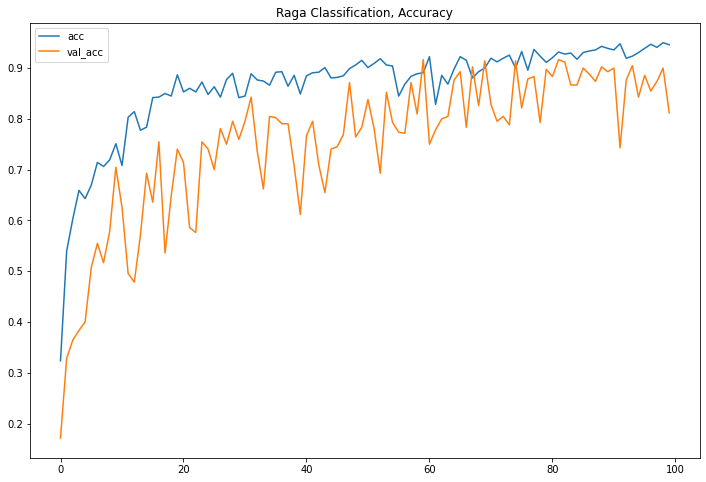

In [31]:
pd.DataFrame(history.history)[['acc', 'val_acc']].plot(figsize = (12,8), title = "Raga Classification, Accuracy")

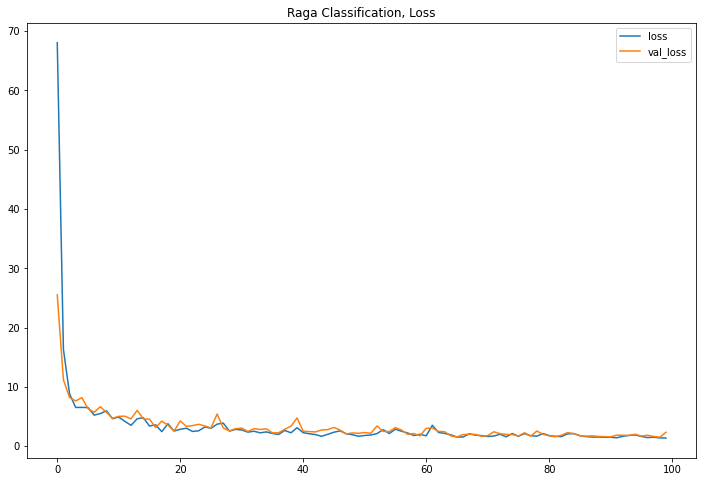

In [32]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize = (12,8), title = "Raga Classification, Loss")